
Initial exploration for Orders:
               id                                            user_id  \
10  2204073066628  62e271062eb827e411bd73941178d29b022f5f2de9d37f...   
20  2204707520644  bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...   
21  2204838822020  329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...   
34  2208967852164  f6451fce7b1c58d0effbe37fcb4e67b718193562766470...   
49  2215889436804  68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...   

            created_at order_date  user_order_seq  \
10 2020-04-30 14:32:19 2020-04-30               1   
20 2020-04-30 17:39:00 2020-04-30               1   
21 2020-04-30 18:12:30 2020-04-30               1   
34 2020-05-01 19:44:11 2020-05-01               1   
49 2020-05-03 21:56:14 2020-05-03               1   

                                        ordered_items  
10  [33618849693828, 33618860179588, 3361887404045...  
20  [33618835243140, 33618835964036, 3361886244058...  
21  [33618891145348, 33618893570180, 3361889766

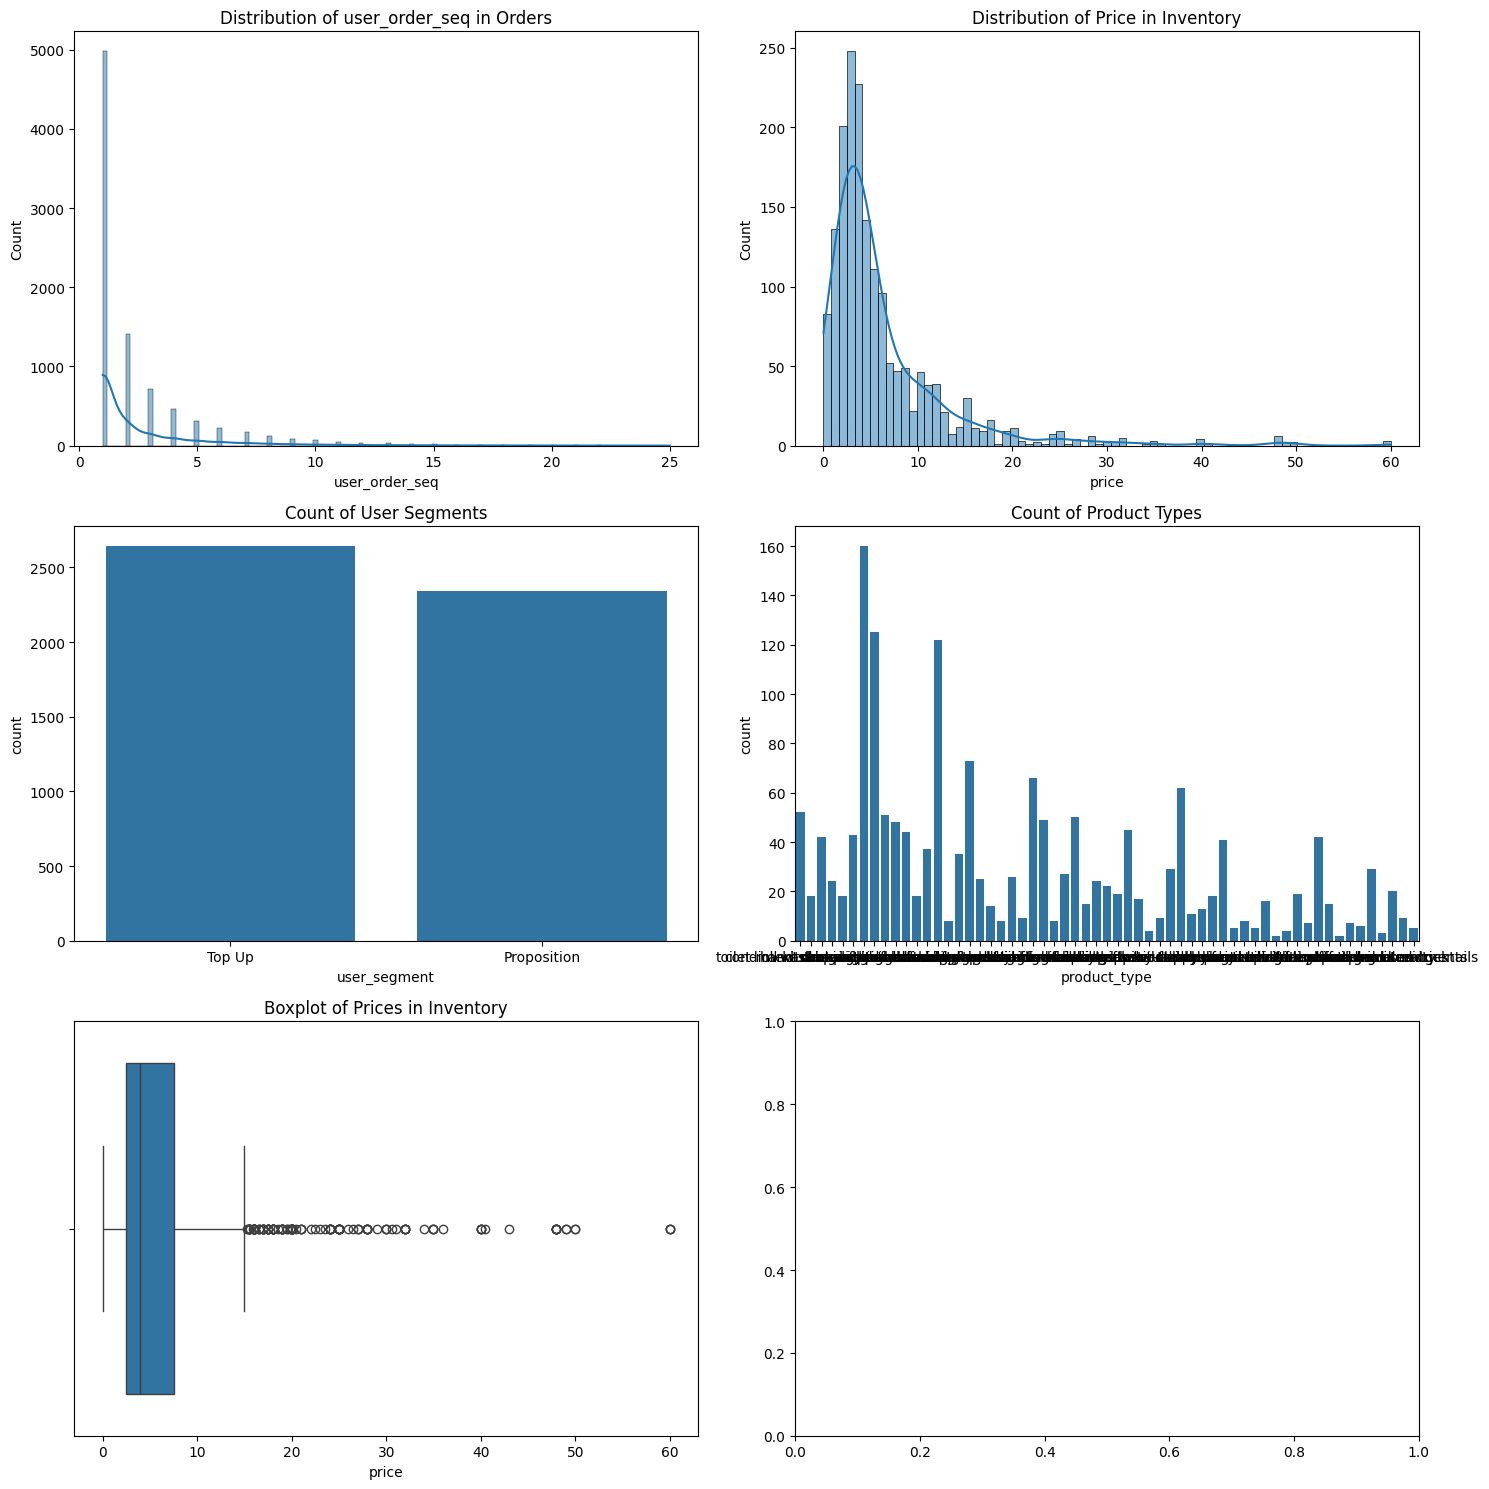

ValueError: could not convert string to float: '62e271062eb827e411bd73941178d29b022f5f2de9d37f50190a1d6741e02be71414684ca6df992c186522a0433f10367d18d7102da301989cb7929559747eda'

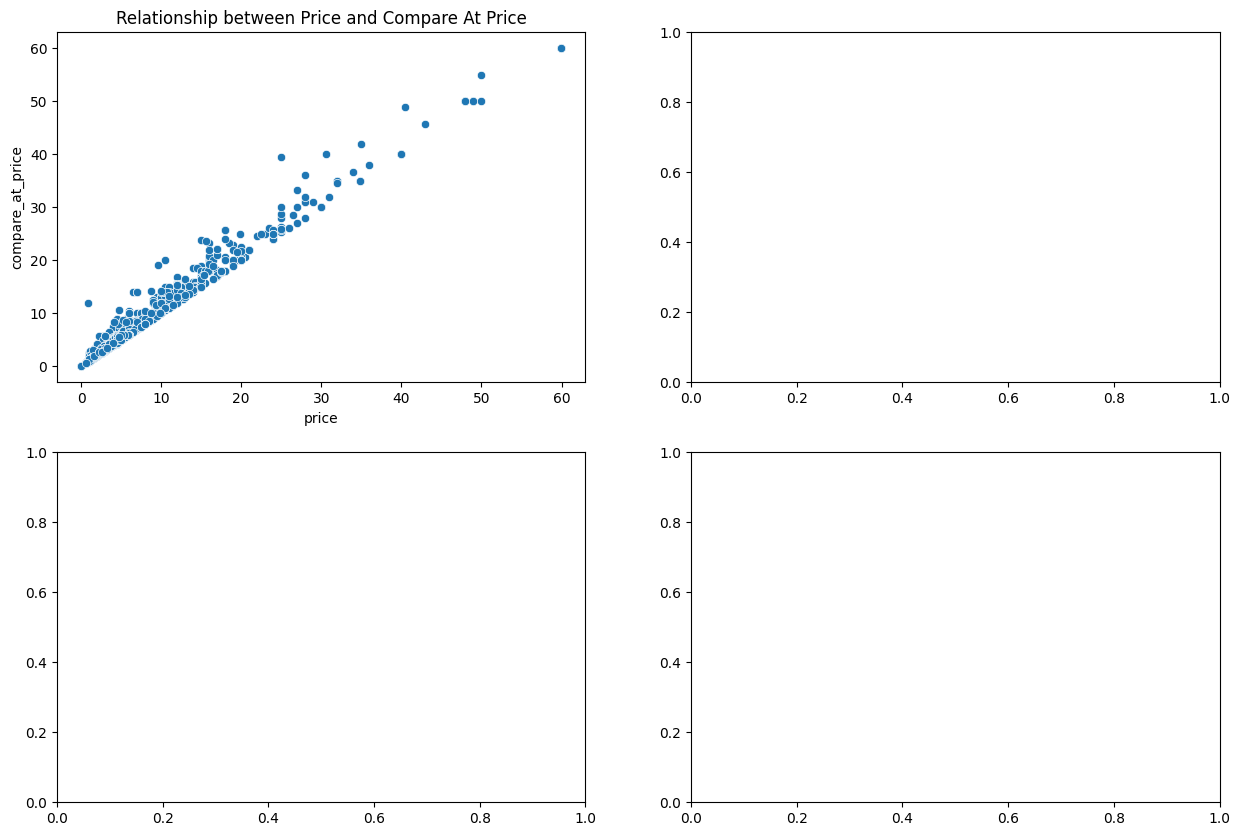

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path where the Parquet files are located
data_path = '/home/eduardo_1999/projects/zrive-ds/projects/zrive-ds/sampled-datasets/'

# Load the Parquet files using the full path
try:
    orders = pd.read_parquet(data_path + 'orders.parquet')
    regulars = pd.read_parquet(data_path + 'regulars.parquet')
    abandoned_cart = pd.read_parquet(data_path + 'abandoned_carts.parquet')  # Ensure to use the correct name
    inventory = pd.read_parquet(data_path + 'inventory.parquet')
    users = pd.read_parquet(data_path + 'users.parquet')
except Exception as e:
    print(f"Error loading data: {e}")

# Convert date columns in the DataFrames
orders['created_at'] = pd.to_datetime(orders['created_at'])
orders['order_date'] = pd.to_datetime(orders['order_date'])
regulars['created_at'] = pd.to_datetime(regulars['created_at'])
abandoned_cart['created_at'] = pd.to_datetime(abandoned_cart['created_at'])

# 3. Initial Data Exploration
dataframes = {
    "Orders": orders,
    "Regulars": regulars,
    "Abandoned Cart": abandoned_cart,
    "Inventory": inventory,
    "Users": users
}

for name, df in dataframes.items():
    print(f"\nInitial exploration for {name}:")
    print(df.head())
    print(df.info())
    print(df.describe(include='all'))  # Include all types of data in description
    print("Null values:", df.isnull().sum())
    
    # Check for complex data types
    complex_columns = []
    for col in df.select_dtypes(include=['object']).columns:
        if df[col].apply(type).eq(list).any():  # Check if any entry in the column is a list
            complex_columns.append(col)

    if complex_columns:
        print(f"Complex columns in {name} that may cause issues: {complex_columns}")

# 4. Data Cleaning
for name, df in dataframes.items():
    # Identify and remove duplicates
    try:
        duplicates = df.duplicated().sum()
        print(f"\nDuplicates in {name}: {duplicates}")
        if duplicates > 0:
            df.drop_duplicates(inplace=True)
    except Exception as e:
        print(f"Error checking duplicates in {name}: {e}")

    # Handle null values
    null_counts = df.isnull().sum()
    print(f"Null values in {name}: {null_counts[null_counts > 0]}")

    # Convert complex columns to string
    for col in complex_columns:
        df[col] = df[col].astype(str)

# 5. Univariate Analysis
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

# Histograms for numeric variables
sns.histplot(orders['user_order_seq'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of user_order_seq in Orders')

sns.histplot(inventory['price'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Price in Inventory')

# Bar charts for categorical variables
sns.countplot(x='user_segment', data=users, ax=axes[2])
axes[2].set_title('Count of User Segments')

sns.countplot(x='product_type', data=inventory, ax=axes[3])
axes[3].set_title('Count of Product Types')

# Boxplot to see the spread of prices
sns.boxplot(x='price', data=inventory, ax=axes[4])
axes[4].set_title('Boxplot of Prices in Inventory')

plt.tight_layout()
plt.show()

# 6. Bivariate Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Scatter plot between price and compare_at_price
sns.scatterplot(x='price', y='compare_at_price', data=inventory, ax=axes[0])
axes[0].set_title('Relationship between Price and Compare At Price')

# Correlation matrix
correlation_matrix = orders.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title('Correlation Matrix of Orders')

# Boxplot of prices by user segment
sns.boxplot(x='user_segment', y='price', data=inventory, ax=axes[2])
axes[2].set_title('Boxplot of Prices by User Segment')

plt.tight_layout()
plt.show()

# 7. Multivariate Analysis
# Pairplot to observe relationships in more variables
sns.pairplot(inventory[['price', 'compare_at_price', 'variant_id']], diag_kind='kde')
plt.title('Pair Plots in Inventory')
plt.show()

# 8. Outlier Detection
# Boxplot to detect outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=inventory['price'])
plt.title('Outlier Detection in Prices')
plt.show()

# 9. Data Visualization
# Visualizations already conducted earlier.

# 10. Hypothesis Formulation
# Formulations to be made based on the analysis:
# - Product prices tend to be correlated with their compare prices.
# - User segmentation may influence purchasing decisions.

# Save cleaned DataFrames if necessary
orders.to_csv(data_path + 'cleaned_orders.csv', index=False)
regulars.to_csv(data_path + 'cleaned_regulars.csv', index=False)
abandoned_cart.to_csv(data_path + 'cleaned_abandoned_cart.csv', index=False)
inventory.to_csv(data_path + 'cleaned_inventory.csv', index=False)
users.to_csv(data_path + 'cleaned_users.csv', index=False)









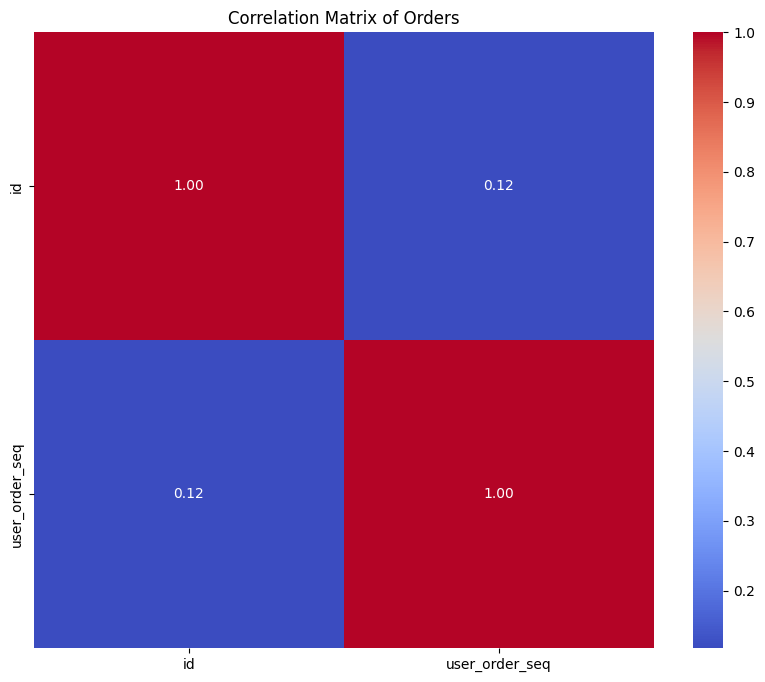

In [30]:
# Select only numeric columns from the 'orders' DataFrame for the correlation matrix
numeric_columns = orders.select_dtypes(include=['number']).columns

# Calculate the correlation matrix only on numeric columns
correlation_matrix = orders[numeric_columns].corr()

# Create a figure and axes for the heatmap
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size as needed

# Plot the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", ax=ax, cmap='coolwarm')
ax.set_title('Correlation Matrix of Orders')

# Show the plot
plt.show()




In [15]:
import pandas as pd

# Define la ruta donde están los archivos Parquet
data_path = '/home/eduardo_1999/projects/zrive-ds/projects/zrive-ds/sampled-datasets/'

# Cargar los archivos Parquet usando la ruta completa
try:
    orders = pd.read_parquet(data_path + 'orders.parquet')
    regulars = pd.read_parquet(data_path + 'regulars.parquet')
    abandoned_cart = pd.read_parquet(data_path + 'abandoned_carts.parquet')  # Asegúrate de usar el nombre correcto
    inventory = pd.read_parquet(data_path + 'inventory.parquet')
    users = pd.read_parquet(data_path + 'users.parquet')

    # Mostrar las primeras filas de cada DataFrame
    print("Orders:")
    print(orders.head())
    print("\nRegulars:")
    print(regulars.head())
    print("\nAbandoned Cart:")
    print(abandoned_cart.head())
    print("\nInventory:")
    print(inventory.head())
    print("\nUsers:")
    print(users.head())
except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Un error ha ocurrido: {e}")


Orders:
               id                                            user_id  \
10  2204073066628  62e271062eb827e411bd73941178d29b022f5f2de9d37f...   
20  2204707520644  bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...   
21  2204838822020  329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...   
34  2208967852164  f6451fce7b1c58d0effbe37fcb4e67b718193562766470...   
49  2215889436804  68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...   

            created_at order_date  user_order_seq  \
10 2020-04-30 14:32:19 2020-04-30               1   
20 2020-04-30 17:39:00 2020-04-30               1   
21 2020-04-30 18:12:30 2020-04-30               1   
34 2020-05-01 19:44:11 2020-05-01               1   
49 2020-05-03 21:56:14 2020-05-03               1   

                                        ordered_items  
10  [33618849693828, 33618860179588, 3361887404045...  
20  [33618835243140, 33618835964036, 3361886244058...  
21  [33618891145348, 33618893570180, 3361889766618...  
34  [33618830196

In [4]:
# Verificar valores faltantes
print("\nValores faltantes en Orders:")
print(orders.isnull().sum())
print("\nValores faltantes en Regulars:")
print(regulars.isnull().sum())
print("\nValores faltantes en Abandoned Cart:")
print(abandoned_cart.isnull().sum())
print("\nValores faltantes en Inventory:")
print(inventory.isnull().sum())
print("\nValores faltantes en Users:")
print(users.isnull().sum())



Valores faltantes en Orders:
id                0
user_id           0
created_at        0
order_date        0
user_order_seq    0
ordered_items     0
dtype: int64

Valores faltantes en Regulars:
user_id       0
variant_id    0
created_at    0
dtype: int64

Valores faltantes en Abandoned Cart:
id            0
user_id       0
created_at    0
variant_id    0
dtype: int64

Valores faltantes en Inventory:
variant_id          0
price               0
compare_at_price    0
vendor              0
product_type        0
tags                0
dtype: int64

Valores faltantes en Users:
user_id                     0
user_segment                0
user_nuts1                 51
first_ordered_at            0
customer_cohort_month       0
count_people             4658
count_adults             4658
count_children           4658
count_babies             4658
count_pets               4658
dtype: int64


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define la ruta donde están los archivos Parquet
data_path = '/home/eduardo_1999/projects/zrive-ds/projects/zrive-ds/sampled-datasets/'

# Cargar los archivos Parquet
orders = pd.read_parquet(data_path + 'orders.parquet')
regulars = pd.read_parquet(data_path + 'regulars.parquet')
abandoned_cart = pd.read_parquet(data_path + 'abandoned_carts.parquet')  
inventory = pd.read_parquet(data_path + 'inventory.parquet')
users = pd.read_parquet(data_path + 'users.parquet')

# Sanity Checks
print("Shapes of datasets:")
print("Orders:", orders.shape)
print("Regulars:", regulars.shape)
print("Abandoned Cart:", abandoned_cart.shape)
print("Inventory:", inventory.shape)
print("Users:", users.shape)

# Revisar tipos de datos y valores nulos
print("\nData Types and Missing Values:")
for df in [orders, regulars, abandoned_cart, inventory, users]:
    print(df.info())

# Análisis de la tasa de abandono del carrito
abandoned_cart[''] = abandoned_cart['user_id'].apply(lambda x: len(x))  # Contar artículos abandonados
sns.histplot(abandoned_cart['item_ids'], bins=20)
plt.title('Distribución de Artículos Abandonados')
plt.xlabel('Número de Artículos Abandonados')
plt.ylabel('Frecuencia')
plt.show()

# Comparación de compras entre usuarios regulares y nuevos
# (Necesitarás definir la lógica para identificar a los clientes regulares y nuevos)

# Análisis de correlación (ejemplo con precios, necesitarás unir datasets adecuados)
# df_merged = pd.merge(orders, inventory, on='item_id')  # Ejemplo de unión
# sns.heatmap(df_merged.corr(), annot=True)
# plt.title('Matriz de Correlación')
# plt.show()


Shapes of datasets:
Orders: (8773, 6)
Regulars: (18105, 3)
Abandoned Cart: (5457, 4)
Inventory: (1733, 6)
Users: (4983, 10)

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8773 non-null   int64         
 1   user_id         8773 non-null   object        
 2   created_at      8773 non-null   datetime64[us]
 3   order_date      8773 non-null   datetime64[us]
 4   user_order_seq  8773 non-null   int64         
 5   ordered_items   8773 non-null   object        
dtypes: datetime64[us](2), int64(2), object(2)
memory usage: 479.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1

KeyError: 'item_ids'

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
print(f"Tamaño del dataset: {df.shape}")
print(df.isnull().sum())

msno.bar(df)
#plt.show()
print(orders.describe())
print(regulars.describe())
print(abandoned_cart.describe())
print(inventory.describe())
print(users.describe())






Tamaño del dataset: (4983, 10)
user_id                     0
user_segment                0
user_nuts1                 51
first_ordered_at            0
customer_cohort_month       0
count_people             4658
count_adults             4658
count_children           4658
count_babies             4658
count_pets               4658
dtype: int64
                 id                  created_at                  order_date  \
count  8.773000e+03                        8773                        8773   
mean   3.684684e+12  2021-08-22 03:54:18.750028  2021-08-21 12:47:21.262966   
min    2.204073e+12         2020-04-30 14:32:19         2020-04-30 00:00:00   
25%    3.690255e+12         2021-04-25 11:50:37         2021-04-25 00:00:00   
50%    3.846692e+12         2021-10-11 11:29:44         2021-10-11 00:00:00   
75%    3.945086e+12         2022-01-03 18:14:23         2022-01-03 00:00:00   
max    4.026732e+12         2022-03-14 00:24:59         2022-03-14 00:00:00   
std    4.145437e+11     

Número total de órdenes: 8773
Promedio de ítems por pedido: 128.00


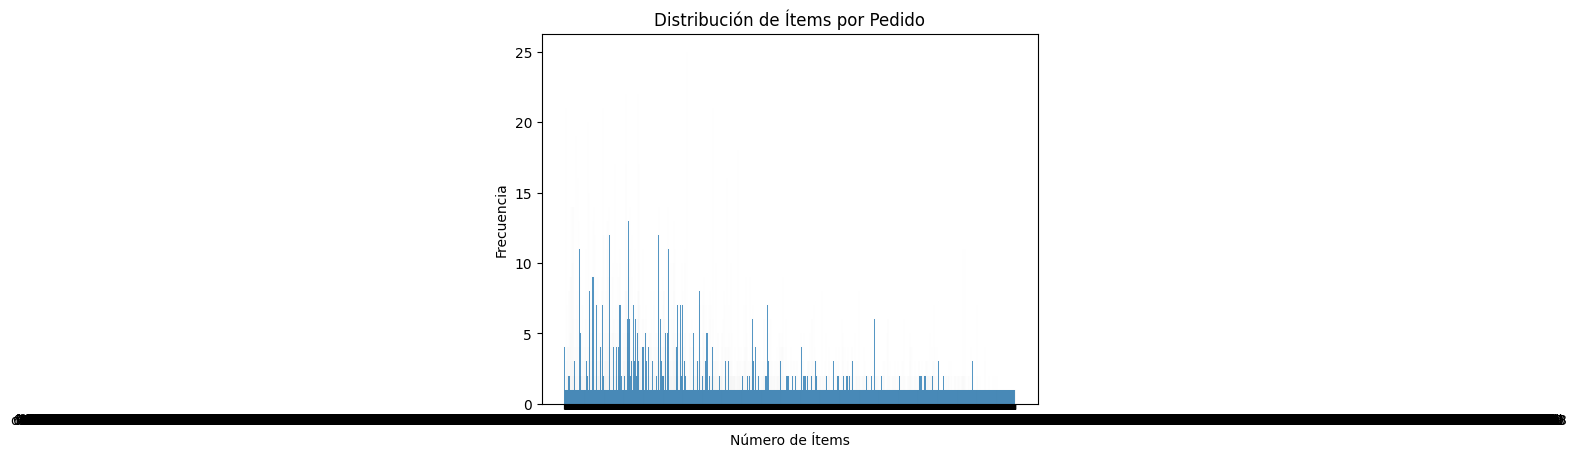

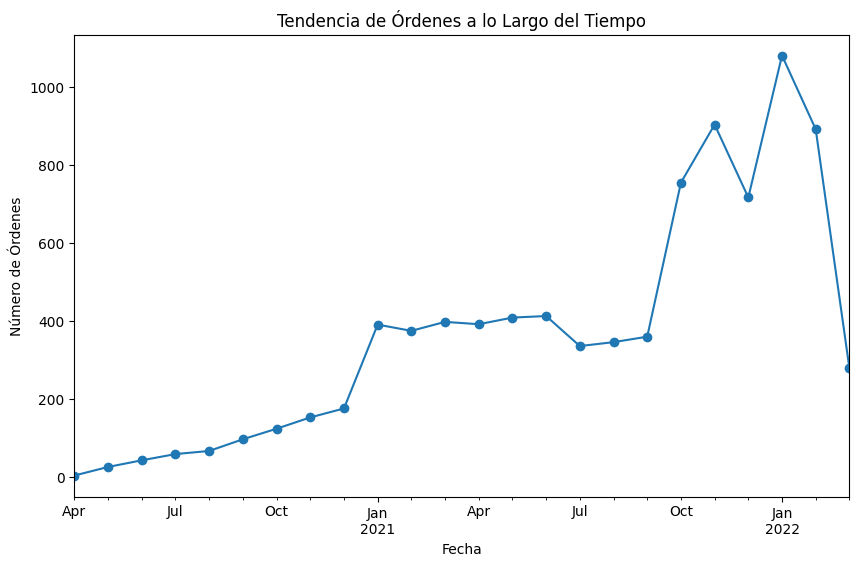

Productos más comprados:
  item_id  count
0       6  71012
3       7  70986
8       4  70983
1       2  70949
7       8  70813


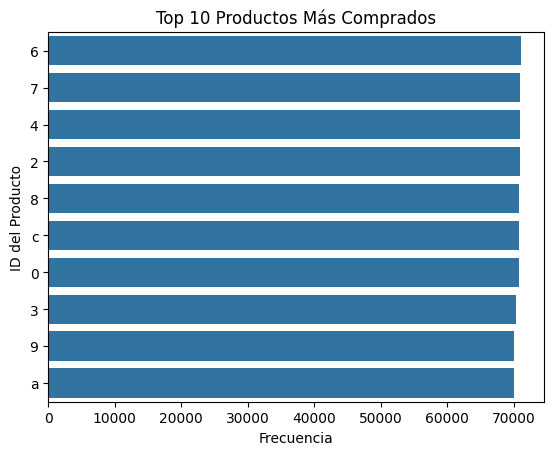

In [38]:
#OrdersAnalysis


import matplotlib.pyplot as plt
#Missingvalues
#msno.bar(orders)

# Número total de órdenes
num_orders = orders.shape[0]
print(f"Número total de órdenes: {num_orders}")

# Calcular el número de ítems por pedido
orders['num_items'] = orders['ordered_items'].apply(len)

# Promedio de ítems por pedido
avg_items_per_order = orders['num_items'].mean()
print(f"Promedio de ítems por pedido: {avg_items_per_order:.2f}")
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de la distribución de ítems por pedido
sns.histplot(orders['ordered_items'], bins=20)
plt.title('Distribución de Ítems por Pedido')
plt.xlabel('Número de Ítems')
plt.ylabel('Frecuencia')
plt.show()

# Asegúrate de que la columna de fecha esté en formato datetime
orders['order_date'] = pd.to_datetime(orders['order_date'])

# Agrupar por mes y contar las órdenes
orders_per_month = orders.groupby(orders['order_date'].dt.to_period('M')).size()

# Visualizar la tendencia de órdenes a lo largo del tiempo
orders_per_month.plot(kind='line', marker='o', figsize=(10,6))
plt.title('Tendencia de Órdenes a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número de Órdenes')
plt.show()

from collections import Counter

# Aplanar la lista de ítems comprados
all_items = [item for sublist in orders['ordered_items'] for item in sublist]

# Contar la frecuencia de cada ítem
item_counts = Counter(all_items)

# Convertir a un DataFrame y mostrar los productos más comprados
item_counts_df = pd.DataFrame(item_counts.items(), columns=['item_id', 'count']).sort_values(by='count', ascending=False)

print("Productos más comprados:")
print(item_counts_df.head())

# Visualización de los productos más comprados
top_items = item_counts_df.head(10)
sns.barplot(x='count', y='item_id', data=top_items)
plt.title('Top 10 Productos Más Comprados')
plt.xlabel('Frecuencia')
plt.ylabel('ID del Producto')
plt.show()


Shape: (18105, 3)
Columns: Index(['user_id', 'variant_id', 'created_at'], dtype='object')
Número de usuarios con ítems regulares: 1448
Items más comunes entre los regulares:
       variant_id  count
0  34081589887108    253
1  34370361229444    127
2  33973249081476    114
3  34370915041412    112
4  34284951863428    105


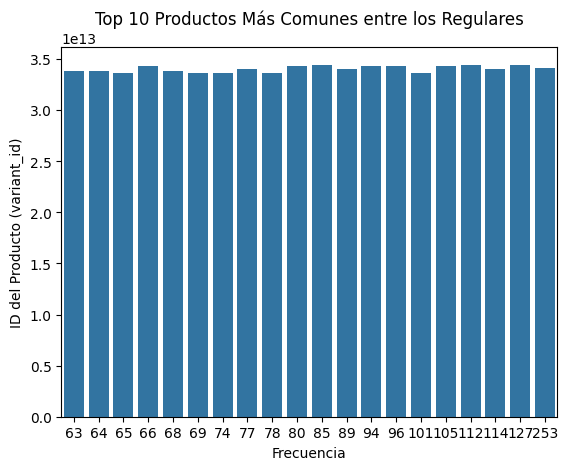

Frecuencia de actualización (número de actualizaciones por mes):
created_at
2020-04     61
2020-05    147
2020-06    167
2020-07    358
2020-08    194
Freq: M, dtype: int64


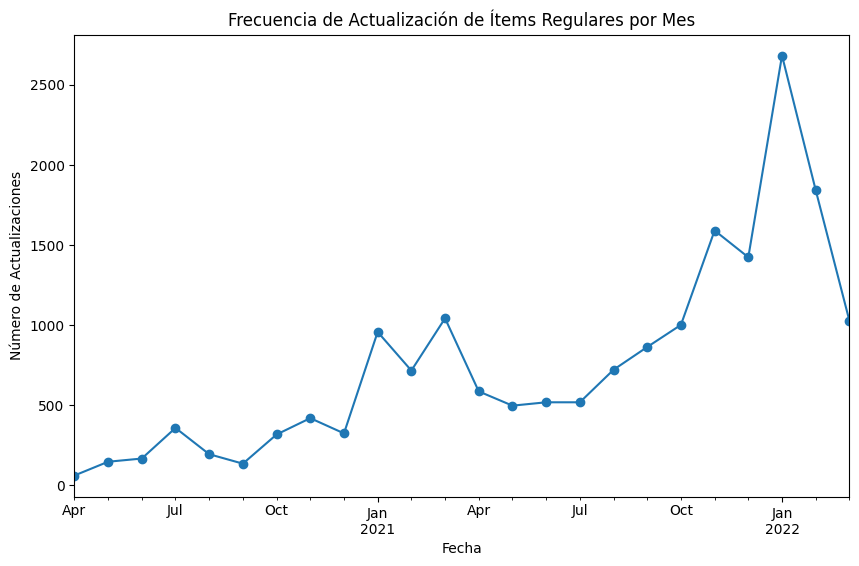

In [47]:

#RegularsAnalysis
# Tamaño y forma del archivo
print(f"Shape: {regulars.shape}")
print(f"Columns: {regulars.columns}")

# Número de usuarios que tienen ítems regulares
num_users_with_regulars = regulars['user_id'].nunique()
print(f"Número de usuarios con ítems regulares: {num_users_with_regulars}")

# Contar la frecuencia de cada producto (variant_id) configurado como regular
most_common_regular_items = regulars['variant_id'].value_counts().reset_index()
most_common_regular_items.columns = ['variant_id', 'count']

# Mostrar los productos más comunes como regulares
print("Items más comunes entre los regulares:")
print(most_common_regular_items.head())

import seaborn as sns
import matplotlib.pyplot as plt

# Visualización de los productos más comunes como regulares
top_regular_items = most_common_regular_items.head(20)
sns.barplot(x='count', y='variant_id', data=top_regular_items)
plt.title('Top 10 Productos Más Comunes entre los Regulares')
plt.xlabel('Frecuencia')
plt.ylabel('ID del Producto (variant_id)')
plt.show()


regulars['created_at'] = pd.to_datetime(regulars['created_at'])

# Agrupar por mes y contar las actualizaciones de ítems regulares
updates_per_month = regulars.groupby(regulars['created_at'].dt.to_period('M')).size()

# Mostrar la frecuencia de actualización de ítems regulares
print("Frecuencia de actualización (número de actualizaciones por mes):")
print(updates_per_month.head())

# Visualización de la frecuencia de actualización a lo largo del tiempo
updates_per_month.plot(kind='line', marker='o', figsize=(10,6))
plt.title('Frecuencia de Actualización de Ítems Regulares por Mes')
plt.xlabel('Fecha')
plt.ylabel('Número de Actualizaciones')
plt.show()


In [55]:
#Abandoned_cart_Analysis

# 1. Número total de carros abandonados
total_abandonos = abandoned_cart['id'].nunique()
print(f"Número total de carros abandonados: {total_abandonos}")

# 2. Frecuencia de abandono por variant_id
frecuencia_abandonos_variant = abandoned_cart.groupby('variant_id')['id'].count().reset_index()
frecuencia_abandonos_variant.columns = ['variant_id', 'cantidad_abandonos']

# Ordenar los items por la cantidad de veces que fueron abandonados
items_mas_abandonados = frecuencia_abandonos_variant.sort_values(by='cantidad_abandonos', ascending=False).head(10)
print("Items más abandonados (por variant_id):")
print(items_mas_abandonados)

# 3. Frecuencia de abandono por usuario
frecuencia_abandonos_usuario = abandoned_cart.groupby('user_id')['id'].count().reset_index()
frecuencia_abandonos_usuario.columns = ['user_id', 'cantidad_abandonos']

# Ordenar los usuarios por la cantidad de abandonos
usuarios_mas_abandonadores = frecuencia_abandonos_usuario.sort_values(by='cantidad_abandonos', ascending=False).head(10)
print("Usuarios que abandonan carros con mayor frecuencia:")
print(usuarios_mas_abandonadores)

# 4. Comparación entre carros abandonados y compras
# Cargar el dataset de orders para realizar la comparación
orders = pd.read_parquet(data_path + 'orders.parquet')

# Obtener los items comprados (en orders)
comprados = orders.explode('ordered_items')['ordered_items'].unique()  # Asegúrate de que 'ordered_items' sea una lista

# Ver si los items abandonados están en los comprados
abandonos_comprados = abandoned_cart[abandoned_cart['variant_id'].isin(comprados)]

# Calcular el número de abandonos que corresponden a compras
total_abandonos_comprados = abandonos_comprados['id'].nunique()
print(f"Número de carros abandonados que también se compraron: {total_abandonos_comprados}")

# Resumen final
print("Resumen del análisis de carros abandonados:")
print(f"Número total de carros abandonados: {total_abandonos}")
print(f"Número de carros abandonados que también se compraron: {total_abandonos_comprados}")



Número total de carros abandonados: 5457
Items más abandonados (por variant_id):
            variant_id  cantidad_abandonos
1240  [34081589887108]                 158
4586  [39709997760644]                  39
1954  [34284950519940]                  24
363   [33667268083844]                  23
1419  [34137590366340]                  21
1661  [34284949766276]                  19
576   [33824368033924]                  17
4645  [39709997858948]                  14
3061  [34543001370756]                  12
1796  [34284950356100]                  11
Usuarios que abandonan carros con mayor frecuencia:
   user_id  cantidad_abandonos
0      128                5457
Número de carros abandonados que también se compraron: 0
Resumen del análisis de carros abandonados:
Número total de carros abandonados: 5457
Número de carros abandonados que también se compraron: 0


In [50]:
#Revision_de_distribución_de_user_id

# Verificar la cantidad de usuarios únicos en el dataset
usuarios_unicos = abandoned_cart['user_id'].nunique()
print(f"Número de usuarios únicos: {usuarios_unicos}")

# Mostrar los primeros 10 valores únicos de 'user_id' para verificar si están duplicados
print(abandoned_cart['user_id'].unique()[:10])

# Contar la frecuencia de cada 'user_id' para ver la distribución
distribucion_usuarios = abandoned_cart['user_id'].value_counts()
print(distribucion_usuarios.head(10))
"Esto es inusual y sugiere que los datos pueden no estar bien representado"




Número de usuarios únicos: 1
[128]
user_id
128    5457
Name: count, dtype: int64


'Esto es inusual y sugiere que los datos pueden no estar bien representado'

In [54]:
#1. Verificación de tipos de datos
#variant_id no es del tipo correcto

# Verificar tipos de datos en abandoned_cart
print(abandoned_cart.dtypes)

# Verificar los tipos de los valores en variant_id
print(abandoned_cart['variant_id'].apply(type).value_counts())
# Asegurarte de que 'variant_id' es un string
abandoned_cart['variant_id'] = abandoned_cart['variant_id'].astype(str)



id                     int64
user_id                int64
created_at    datetime64[us]
variant_id            object
dtype: object
variant_id
<class 'numpy.ndarray'>    5457
Name: count, dtype: int64


Primeras filas del inventario:
       variant_id  price  compare_at_price          vendor  \
0  39587297165444   3.09              3.15           heinz   
1  34370361229444   4.99              5.50   whogivesacrap   
2  34284951863428   3.69              3.99          plenty   
3  33667283583108   1.79              1.99  thecheekypanda   
4  33803537973380   1.99              2.09         colgate   

                      product_type                                        tags  
0             condiments-dressings                       [table-sauces, vegan]  
1  toilet-roll-kitchen-roll-tissue                 [b-corp, eco, toilet-rolls]  
2  toilet-roll-kitchen-roll-tissue                              [kitchen-roll]  
3  toilet-roll-kitchen-roll-tissue  [b-corp, cruelty-free, eco, tissue, vegan]  
4                           dental                        [dental-accessories]  

Tipos de productos en el inventario:
['condiments-dressings' 'toilet-roll-kitchen-roll-tissue' 'dental'
 'han

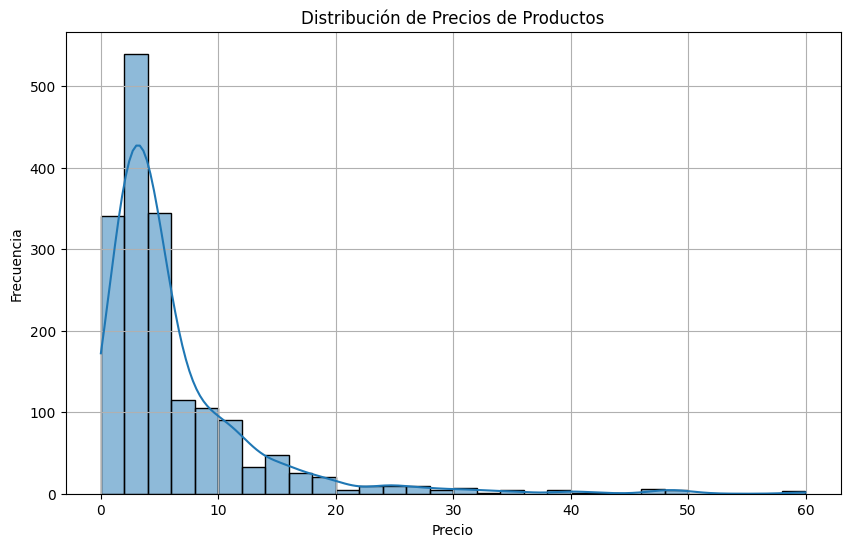


Frecuencia de categorías de productos:
product_type
cleaning-products                  160
tins-packaged-foods                125
snacks-confectionery               122
cooking-ingredients                 73
pasta-rice-noodles                  66
baby-toddler-food                   62
condiments-dressings                52
cereal                              51
haircare                            50
biscuits-crackers                   49
soft-drinks-mixers                  48
baby-kids-toiletries                45
skincare                            44
cooking-sauces                      43
dog-food                            42
dental                              42
baby-accessories                    41
superfoods-supplements              37
cat-food                            35
shaving-grooming                    29
nappies-nappy-pants                 29
dishwashing                         27
period-care                         26
home-baking                         25
hand-soap-s

In [56]:
#Inventory_Analisys
import pandas as pd

# Define la ruta donde está el archivo Parquet
data_path = '/home/eduardo_1999/projects/zrive-ds/projects/zrive-ds/sampled-datasets/'

# Cargar el archivo inventory
inventory = pd.read_parquet(data_path + 'inventory.parquet')

# 1. Información detallada de los ítems
print("Primeras filas del inventario:")
print(inventory.head())

# Tipos únicos de productos
tipos_productos = inventory['product_type'].unique()
print("\nTipos de productos en el inventario:")
print(tipos_productos)

# 2. Stock de productos (asumiendo que 'active' significa que están disponibles)
# Si no hay una columna específica que indique esto, es posible que se necesite otro método
# Aquí se sugiere usar el count de 'variant_id'
num_productos = inventory['variant_id'].nunique()
print(f"\nNúmero total de productos únicos en el inventario: {num_productos}")

# 3. Rangos de precios
print("\nRangos de precios:")
print(inventory['price'].describe())

# Visualización de la distribución de precios
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(inventory['price'], bins=30, kde=True)
plt.title('Distribución de Precios de Productos')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

# 4. Análisis de categorías
# Analizando las categorías por 'product_type'
categorias_frecuencia = inventory['product_type'].value_counts()
print("\nFrecuencia de categorías de productos:")
print(categorias_frecuencia)

# También se pueden analizar los tags, si es necesario
# Extraer las etiquetas en caso de que sea necesario
# inventory['tags'] es un string, puede que necesites convertirlo a una lista primero
# Ejemplo: Si tags son strings separados por comas
inventory['tags'] = inventory['tags'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
tags_frecuencia = inventory.explode('tags')['tags'].value_counts()
print("\nFrecuencia de etiquetas de productos:")
print(tags_frecuencia.head(10))  # Muestra las 10 etiquetas más comunes


In [57]:
#Users_Analysis

import pandas as pd

# Define la ruta donde está el archivo Parquet
data_path = '/home/eduardo_1999/projects/zrive-ds/projects/zrive-ds/sampled-datasets/'

# Cargar el archivo users
users = pd.read_parquet(data_path + 'users.parquet')

# 1. Distribución geográfica (omitir si no hay datos de ubicación)
# Si hubiera una columna de ubicación, podrías hacer algo como:
# if 'location_column' in users.columns:
#     print("Distribución geográfica:")
#     print(users['location_column'].value_counts())

# 2. Tamaño de la base de usuarios
num_usuarios_unicos = users['user_id'].nunique()
print(f"Número total de usuarios únicos: {num_usuarios_unicos}")

# 3. Análisis de retención
# Suponiendo que 'first_ordered_at' indica la primera fecha de pedido de cada usuario
# Debemos contar cuántos pedidos hay por cada usuario
usuarios_con_pedidos = users[users['first_ordered_at'].notnull()]
usuarios_retenidos = usuarios_con_pedidos['user_id'].nunique()  # Total de usuarios con al menos un pedido

# Si hay otra columna que registre los pedidos, podrías contar los pedidos por usuario
# En este caso, como no se tiene esa información en el DataFrame users, solo mostraremos usuarios únicos
print(f"Número total de usuarios que han hecho al menos un pedido: {usuarios_retenidos}")

# 4. Segmentación por actividad
# Supongamos que 'user_segment' categoriza a los usuarios. Podríamos contar cuántos usuarios hay por segmento.
segmentos_usuarios = users['user_segment'].value_counts()
print("\nSegmentación de usuarios por actividad:")
print(segmentos_usuarios)




Número total de usuarios únicos: 4983
Número total de usuarios que han hecho al menos un pedido: 4983

Segmentación de usuarios por actividad:
user_segment
Top Up         2643
Proposition    2340
Name: count, dtype: int64


In [68]:
#Analysis_Combinado

#Pedidos_con_usuarios

# Unir los datos de pedidos con los datos de usuarios
merged_orders_users = orders.merge(users, on='user_id', how='left')

# Ejemplo de análisis: Comportamiento de compra por segmentación de usuarios
# Por ejemplo, promedio de ítems por pedido por segmento de usuario
promedio_items_por_segmento = merged_orders_users.groupby('user_segment')['ordered_items'].apply(lambda x: x.str.len().mean())
print("Promedio de ítems por pedido por segmento de usuario:")
print(promedio_items_por_segmento)

# Comparar_Inventario_con_carros_abandonados

import pandas as pd

# Contar los ítems en el inventario
productos_inventario = inventory['variant_id'].unique()

# Contar los ítems abandonados
productos_abandonados = abandoned_cart['variant_id'].value_counts()

# Crear un DataFrame para comparar
comparacion_inventario_abandonados = pd.DataFrame({
    'cantidad_abandonos': productos_abandonados,
    'en_inventario': [variant_id in productos_inventario for variant_id in productos_abandonados.index]
})

# Definir el threshold, por ejemplo, usando el percentil 75
threshold = comparacion_inventario_abandonados['cantidad_abandonos'].quantile(0.75)

# Filtrar los productos que están en el inventario pero tienen altos índices de abandono
productos_alto_abandono = comparacion_inventario_abandonados[comparacion_inventario_abandonados['cantidad_abandonos'] > threshold]
print("Productos con alto índice de abandono en inventario:")
print(productos_alto_abandono)

# Convertir variant_id a string en ambos DataFrames
regulars['variant_id'] = regulars['variant_id'].astype(str)
abandoned_cart['variant_id'] = abandoned_cart['variant_id'].astype(str)

#3. Analizar el Cruce entre Productos Regulares y Abandonados
print(regulars.dtypes)
print(abandoned_cart.dtypes)
# Unir productos regulares con carros abandonados
cruce_regulares_abandonados = regulars.merge(abandoned_cart, on='variant_id', how='inner')

# Ejemplo de análisis: contar cuántos productos regulares fueron abandonados
conteo_regulares_abandonados = cruce_regulares_abandonados['variant_id'].value_counts().sum()
print("Conteo de productos regulares que fueron abandonados:")
print(conteo_regulares_abandonados)

# Ver valores únicos en cada DataFrame
print("Valores únicos de variant_id en regulars:")
print(regulars['variant_id'].unique())
print("Valores únicos de variant_id en abandoned_cart:")
print(abandoned_cart['variant_id'].unique())


# Contar valores nulos en variant_id
print("Valores nulos en regulars:")
print(regulars['variant_id'].isnull().sum())
print("Valores nulos en abandoned_cart:")
print(abandoned_cart['variant_id'].isnull().sum())

print("Tipo de variant_id en regulars:", regulars['variant_id'].dtype)
print("Tipo de variant_id en abandoned_cart:", abandoned_cart['variant_id'].dtype)

# Quitar espacios en blanco y convertir a string
regulars['variant_id'] = regulars['variant_id'].astype(str).str.strip()
abandoned_cart['variant_id'] = abandoned_cart['variant_id'].astype(str).str.strip()

# Realizar la unión nuevamente
cruce_regulares_abandonados = regulars.merge(abandoned_cart, on='variant_id', how='inner')

# Contar cuántos productos regulares fueron abandonados
conteo_regulares_abandonados = cruce_regulares_abandonados['variant_id'].value_counts()
print("Conteo de productos regulares que fueron abandonados:")
print(conteo_regulares_abandonados)


Promedio de ítems por pedido por segmento de usuario:
user_segment
Proposition    15.650706
Top Up          9.265666
Name: ordered_items, dtype: float64
Productos con alto índice de abandono en inventario:
                                 cantidad_abandonos  en_inventario
variant_id                                                        
[34081589887108]                                158          False
[39709997760644]                                 39          False
[34284950519940]                                 24          False
[33667268083844]                                 23          False
[34137590366340]                                 21          False
...                                             ...            ...
[34460976775300]                                  2          False
[33826415280260]                                  2          False
[39709997760644 34284950519940]                   2          False
[34415987523716 34137590366340]                   2      

In [22]:
# Verificar tipos de datos
print("Tipos de datos en Orders:")
print(orders.dtypes)
print("\nTipos de datos en Regulars:")
print(regulars.dtypes)
print("\nTipos de datos en Abandoned Cart:")
print(abandoned_cart.dtypes)
print("\nTipos de datos en Inventory:")
print(inventory.dtypes)
print("\nTipos de datos en Users:")
print(users.dtypes)

Tipos de datos en Orders:
id                         int64
user_id                   object
created_at        datetime64[us]
order_date        datetime64[us]
user_order_seq             int64
ordered_items             object
dtype: object

Tipos de datos en Regulars:
user_id               object
variant_id             int64
created_at    datetime64[us]
dtype: object

Tipos de datos en Abandoned Cart:
id                     int64
user_id               object
created_at    datetime64[us]
variant_id            object
dtype: object

Tipos de datos en Inventory:
variant_id            int64
price               float64
compare_at_price    float64
vendor               object
product_type         object
tags                 object
dtype: object

Tipos de datos en Users:
user_id                   object
user_segment              object
user_nuts1                object
first_ordered_at          object
customer_cohort_month     object
count_people             float64
count_adults             float6

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define la ruta donde están los archivos Parquet
data_path = '/home/eduardo_1999/projects/zrive-ds/projects/zrive-ds/sampled-datasets/'

# Cargar los archivos Parquet usando la ruta completa
try:
    orders = pd.read_parquet(data_path + 'orders.parquet')
    regulars = pd.read_parquet(data_path + 'regulars.parquet')
    abandoned_cart = pd.read_parquet(data_path + 'abandoned_carts.parquet')
    inventory = pd.read_parquet(data_path + 'inventory.parquet')
    users = pd.read_parquet(data_path + 'users.parquet')
except Exception as e:
    print(f"Error loading data: {e}")

# Inspect the orders DataFrame to identify available columns
print("Columns in orders DataFrame:", orders.columns)

# Hipótesis sobre la Tasa de Conversión
def check_conversion_rate(orders, users):
    previous_users = orders['user_id'].unique()
    new_users = users[~users['user_id'].isin(previous_users)]

    # Tasa de conversión
    conversion_rate_previous = len(previous_users) / len(users) * 100
    conversion_rate_new = len(new_users) / len(users) * 100

    print(f"Conversion rate for previous users: {conversion_rate_previous:.2f}%")
    print(f"Conversion rate for new users: {conversion_rate_new:.2f}%")

# Hipótesis sobre Carritos Abandonados
def check_abandoned_cart_prices(abandoned_cart, orders):
    # Calcular precios de carritos abandonados
    abandoned_cart_total_price = abandoned_cart.groupby('user_id').agg(total_price_abandoned=('variant_id', 'count')).reset_index()
    
    # Check available columns in orders
    print("Columns in orders for aggregation:", orders.columns)

    # Initialize variable
    converted_cart_total_price = None

    # Check if 'price' column exists in orders
    if 'price' in orders.columns:
        converted_cart_total_price = orders.groupby('user_id').agg(total_price_converted=('price', 'sum')).reset_index()
    else:
        print("Warning: 'price' column does not exist in orders DataFrame. Skipping conversion price analysis.")

    # Proceed with analysis if converted_cart_total_price is available
    if converted_cart_total_price is not None:
        # Análisis de precios
        merged = abandoned_cart_total_price.merge(
            converted_cart_total_price, 
            on='user_id', 
            suffixes=('_abandoned', '_converted'), 
            how='outer'
        )

        plt.figure(figsize=(12, 6))
        sns.boxplot(data=merged[['total_price_abandoned', 'total_price_converted']])
        plt.title('Boxplot of Total Prices of Abandoned Carts vs Converted Carts')
        plt.ylabel('Total Price')
        plt.xticks([0, 1], ['Abandoned', 'Converted'])
        plt.show()

        print(f"Average abandoned cart price: {merged['total_price_abandoned'].mean():.2f}")
        print(f"Average converted cart price: {merged['total_price_converted'].mean():.2f}")
    else:
        print("No converted cart data available for analysis.")

def check_cart_abandonment_rate(abandoned_cart):
    total_carts = len(abandoned_cart)
    abandoned_rate = total_carts / (total_carts + len(orders)) * 100

    print(f"Cart abandonment rate: {abandoned_rate:.2f}%")

# Hipótesis sobre Segmentación de Usuarios
def check_user_segments(users, orders):
    segment_comparisons = orders['user_id'].value_counts().reset_index()
    segment_comparisons.columns = ['user_id', 'purchase_count']

    users_with_purchases = users.merge(segment_comparisons, on='user_id', how='left').fillna(0)
    top_up_avg = users_with_purchases[users_with_purchases['user_segment'] == 'Top Up']['purchase_count'].mean()
    proposition_avg = users_with_purchases[users_with_purchases['user_segment'] == 'Proposition']['purchase_count'].mean()

    print(f"Average purchases for 'Top Up': {top_up_avg:.2f}")
    print(f"Average purchases for 'Proposition': {proposition_avg:.2f}")

    demographic_columns = ['count_adults', 'count_children', 'count_babies', 'count_pets']
    for col in demographic_columns:
        correlation = users_with_purchases[col].corr(users_with_purchases['purchase_count'])
        print(f"Correlation between {col} and purchase count: {correlation:.2f}")

# Hipótesis sobre el Inventario
def check_inventory(inventory, orders):
    eco_products = inventory[inventory['tags'].str.contains('eco')]
    eco_purchase_count = orders[orders['variant_id'].isin(eco_products['variant_id'])].shape[0]

    total_eco_products = eco_products.shape[0]
    eco_purchase_rate = (eco_purchase_count / total_eco_products) * 100 if total_eco_products else 0

    print(f"Eco product purchase rate: {eco_purchase_rate:.2f}%")

    sales_data = orders.groupby('variant_id').size().reset_index(name='sales_count')
    merged_inventory = inventory.merge(sales_data, on='variant_id', how='left').fillna(0)
    correlation_price_sales = merged_inventory['price'].corr(merged_inventory['sales_count'])

    print(f"Correlation between price and sales count: {correlation_price_sales:.2f}")

# Hipótesis sobre Tiempo y Frecuencia de Compra
def check_purchase_frequency(orders):
    orders['order_day'] = orders['order_date'].dt.day_name()
    purchase_frequency = orders['order_day'].value_counts()

    plt.figure(figsize=(12, 6))
    sns.barplot(x=purchase_frequency.index, y=purchase_frequency.values)
    plt.title('Purchase Frequency by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Purchases')
    plt.xticks(rotation=45)
    plt.show()

# Ejecutar las comprobaciones de hipótesis
check_conversion_rate(orders, users)
check_abandoned_cart_prices(abandoned_cart, orders)
check_cart_abandonment_rate(abandoned_cart)
check_user_segments(users, orders)
check_inventory(inventory, orders)
check_purchase_frequency(orders)





Columns in orders DataFrame: Index(['id', 'user_id', 'created_at', 'order_date', 'user_order_seq',
       'ordered_items'],
      dtype='object')
Conversion rate for previous users: 100.00%
Conversion rate for new users: 0.00%
Columns in orders for aggregation: Index(['id', 'user_id', 'created_at', 'order_date', 'user_order_seq',
       'ordered_items'],
      dtype='object')
No converted cart data available for analysis.
Cart abandonment rate: 38.35%
Average purchases for 'Top Up': 1.74
Average purchases for 'Proposition': 1.79
Correlation between count_adults and purchase count: 0.10
Correlation between count_children and purchase count: 0.07
Correlation between count_babies and purchase count: 0.03
Correlation between count_pets and purchase count: 0.05


KeyError: "None of [Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n       ...\n       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],\n      dtype='float64', length=1733)] are in the [columns]"

Abandoned Cart Data Types:
id                     int64
user_id               object
created_at    datetime64[us]
variant_id            object
dtype: object

Orders Data Types:
id                         int64
user_id                   object
created_at        datetime64[us]
order_date        datetime64[us]
user_order_seq             int64
ordered_items             object
dtype: object

Abandoned Cart NaN Values:
id            0
user_id       0
created_at    0
variant_id    0
dtype: int64

Orders NaN Values:
id                0
user_id           0
created_at        0
order_date        0
user_order_seq    0
ordered_items     0
dtype: int64


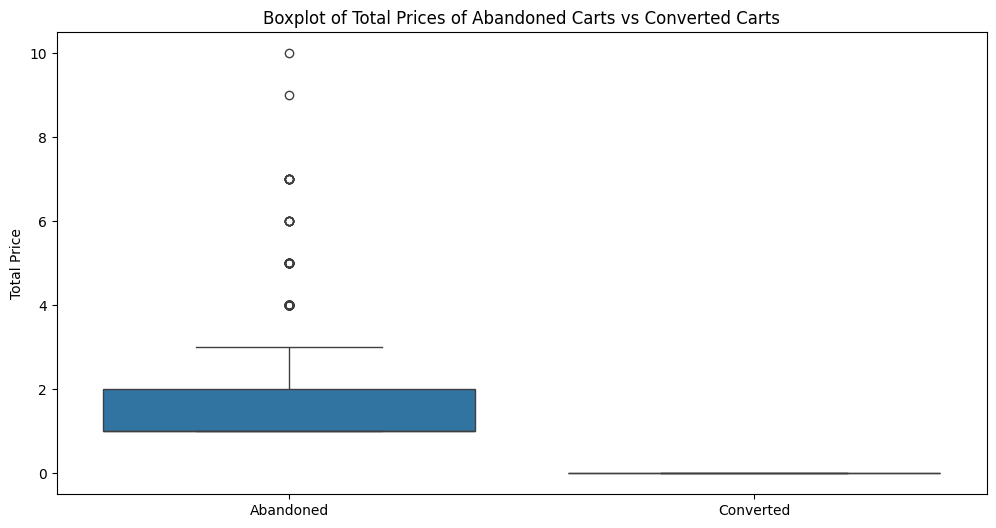

Average abandoned cart price: 1.59
Average converted cart price: 0.00
Cart abandonment rate: 38.35%


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def check_abandoned_cart_prices(abandoned_cart, orders):
    # Check data types
    print("Abandoned Cart Data Types:")
    print(abandoned_cart.dtypes)
    print("\nOrders Data Types:")
    print(orders.dtypes)
    
    # Check for NaN values
    print("\nAbandoned Cart NaN Values:")
    print(abandoned_cart.isna().sum())
    print("\nOrders NaN Values:")
    print(orders.isna().sum())

    # Ensure that 'ordered_items' is numeric
    orders['ordered_items'] = pd.to_numeric(orders['ordered_items'], errors='coerce')

    # Calculate total price of abandoned carts
    abandoned_cart_total_price = abandoned_cart.groupby('user_id').agg(total_price=('variant_id', 'count')).reset_index()
    
    # Calculate total price of converted carts
    converted_cart_total_price = orders.groupby('user_id').agg(total_price=('ordered_items', 'sum')).reset_index()

    # Merge results for analysis
    merged = abandoned_cart_total_price.merge(converted_cart_total_price, on='user_id', suffixes=('_abandoned', '_converted'))

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=merged[['total_price_abandoned', 'total_price_converted']])
    plt.title('Boxplot of Total Prices of Abandoned Carts vs Converted Carts')
    plt.ylabel('Total Price')
    plt.xticks([0, 1], ['Abandoned', 'Converted'])
    plt.show()

    print(f"Average abandoned cart price: {merged['total_price_abandoned'].mean():.2f}")
    print(f"Average converted cart price: {merged['total_price_converted'].mean():.2f}")

def check_cart_abandonment_rate(abandoned_cart, orders):
    # Tasa de abandono de carritos
    total_carts = len(abandoned_cart)
    abandoned_rate = total_carts / (total_carts + len(orders)) * 100  # Considering converted carts as orders

    print(f"Cart abandonment rate: {abandoned_rate:.2f}%")

# Ensure you pass both abandoned_cart and orders DataFrames
check_abandoned_cart_prices(abandoned_cart, orders)
check_cart_abandonment_rate(abandoned_cart, orders)


In [42]:
# Hipótesis sobre Segmentación de Usuarios
def check_user_segments(users, orders):
    # Comparar el número de compras entre segmentos
    segment_comparisons = orders['user_id'].value_counts().reset_index()
    segment_comparisons.columns = ['user_id', 'purchase_count']

    users_with_purchases = users.merge(segment_comparisons, on='user_id', how='left').fillna(0)
    top_up_avg = users_with_purchases[users_with_purchases['user_segment'] == 'Top Up']['purchase_count'].mean()
    proposition_avg = users_with_purchases[users_with_purchases['user_segment'] == 'Proposition']['purchase_count'].mean()

    print(f"Average purchases for 'Top Up': {top_up_avg:.2f}")
    print(f"Average purchases for 'Proposition': {proposition_avg:.2f}")

    # Demografía
    demographic_columns = ['count_adults', 'count_children', 'count_babies', 'count_pets']
    for col in demographic_columns:
        correlation = users_with_purchases[col].corr(users_with_purchases['purchase_count'])
        print(f"Correlation between {col} and purchase count: {correlation:.2f}")

check_user_segments(users, orders)


Average purchases for 'Top Up': 1.74
Average purchases for 'Proposition': 1.79
Correlation between count_adults and purchase count: 0.10
Correlation between count_children and purchase count: 0.07
Correlation between count_babies and purchase count: 0.03
Correlation between count_pets and purchase count: 0.05


In [51]:
def check_inventory(inventory, orders):
    # Check if 'tags' and 'variant_id' columns exist in the inventory
    required_columns = ['tags', 'variant_id']
    for col in required_columns:
        if col not in inventory.columns:
            print(f"Error: '{col}' column does not exist in inventory DataFrame.")
            return

    # Handle NaN values in the 'tags' column
    inventory['tags'] = inventory['tags'].fillna('')

    # Filter eco products
    eco_products = inventory[inventory['tags'].str.contains('eco', na=False)]
    
    # Count purchases of eco products
    eco_purchase_count = orders[orders['variant_id'].isin(eco_products['variant_id'])].shape[0]
    total_eco_products = eco_products.shape[0]
    
    # Calculate eco product purchase rate
    eco_purchase_rate = (eco_purchase_count / total_eco_products) * 100 if total_eco_products else 0
    print(f"Eco product purchase rate: {eco_purchase_rate:.2f}%")

    # Create sales data
    sales_data = orders.groupby('variant_id').size().reset_index(name='sales_count')
    
    # Merge inventory with sales data
    merged_inventory = inventory.merge(sales_data, on='variant_id', how='left').fillna(0)

    # Check if 'price' column exists in merged_inventory
    if 'price' in merged_inventory.columns:
        # Calculate correlation between price and sales count
        correlation_price_sales = merged_inventory['price'].corr(merged_inventory['sales_count'])
        print(f"Correlation between price and sales count: {correlation_price_sales:.2f}")
    else:
        print("Warning: 'price' column does not exist in merged inventory DataFrame. Cannot compute correlation.")

# Call the function
check_inventory(inventory, orders)



KeyError: 'variant_id'

In [14]:
import pandas as pd

# Definir la ruta a los datos
data_path = '/home/eduardo_1999/projects/zrive-ds/projects/zrive-ds/sampled-datasets/'

# Cargar los archivos parquet
orders = pd.read_parquet(data_path + 'orders.parquet')
regulars = pd.read_parquet(data_path + 'regulars.parquet')
abandoned_cart = pd.read_parquet(data_path + 'abandoned_carts.parquet')  # Asegúrate de usar el nombre correcto
inventory = pd.read_parquet(data_path + 'inventory.parquet')
users = pd.read_parquet(data_path + 'users.parquet')

# Función para analizar DataFrames
def analyze_dataframe(df, name):
    print(f"\nAnálisis de '{name}':")
    
    # Ver las columnas
    print("Columnas:", df.columns.tolist())
    
    # Información general del DataFrame
    print("Información general:")
    df.info()
    
    # Ver las primeras filas
    print("Primeras filas:")
    print(df.head())
    
    # Descripción estadística del DataFrame
    print("Resumen estadístico:")
    print(df.describe(include='all'))
    
    # Tipos de datos de cada columna
    print("Tipos de datos:")
    print(df.dtypes)
    
    # Ver valores únicos por columna
    print("Valores únicos por columna:")
    print(df.nunique())

# Analizar cada DataFrame
analyze_dataframe(orders, "orders")
analyze_dataframe(regulars, "regulars")
analyze_dataframe(abandoned_cart, "abandoned_cart")
analyze_dataframe(inventory, "inventory")
analyze_dataframe(users, "users")



Análisis de 'orders':
Columnas: ['id', 'user_id', 'created_at', 'order_date', 'user_order_seq', 'ordered_items']
Información general:
<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8773 non-null   int64         
 1   user_id         8773 non-null   object        
 2   created_at      8773 non-null   datetime64[us]
 3   order_date      8773 non-null   datetime64[us]
 4   user_order_seq  8773 non-null   int64         
 5   ordered_items   8773 non-null   object        
dtypes: datetime64[us](2), int64(2), object(2)
memory usage: 479.8+ KB
Primeras filas:
               id                                            user_id  \
10  2204073066628  62e271062eb827e411bd73941178d29b022f5f2de9d37f...   
20  2204707520644  bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...   
21  2204838822020  329f08c66abb51f8c0b8a952

TypeError: unhashable type: 'numpy.ndarray'

Análisis

In [12]:
import pandas as pd

data_path = '/home/eduardo_1999/projects/zrive-ds/projects/zrive-ds/sampled-datasets/'

# Cargar los archivos Parquet usando la ruta completa
try:
    orders = pd.read_parquet(data_path + 'orders.parquet')
    regulars = pd.read_parquet(data_path + 'regulars.parquet')
    abandoned_cart = pd.read_parquet(data_path + 'abandoned_carts.parquet')  # Asegúrate de usar el nombre correcto
    inventory = pd.read_parquet(data_path + 'inventory.parquet')
    users = pd.read_parquet(data_path + 'users.parquet')

    # Lista de DataFrames cargados
    dataframes = [orders, regulars, abandoned_cart, inventory, users]
    names = ['orders', 'regulars', 'abandoned_cart', 'inventory', 'users']

    # Bucle para imprimir el info() de cada DataFrame
    for df, name in zip(dataframes, names):
        print(f"DataFrame: {name}")
        df.info()
        print(df.head())  # Muestra la información estructural de cada DataFrame
        print("\n" + "-"*50 + "\n")  # Separador para mejor visualización

# Bloque except para manejar errores
except Exception as e:
    print(f"Ocurrió un error al cargar los archivos Parquet: {e}")


DataFrame: orders
<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8773 non-null   int64         
 1   user_id         8773 non-null   object        
 2   created_at      8773 non-null   datetime64[us]
 3   order_date      8773 non-null   datetime64[us]
 4   user_order_seq  8773 non-null   int64         
 5   ordered_items   8773 non-null   object        
dtypes: datetime64[us](2), int64(2), object(2)
memory usage: 479.8+ KB
               id                                            user_id  \
10  2204073066628  62e271062eb827e411bd73941178d29b022f5f2de9d37f...   
20  2204707520644  bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...   
21  2204838822020  329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...   
34  2208967852164  f6451fce7b1c58d0effbe37fcb4e67b718193562766470...   
49  2215889436804  68e872ff88830

1.Profiling ourbuyers 
2.Analyse regulars 
3.Reconstruct orders and abandoned orders with inventory information.

Lo mas interesante es ver como son nuestros usuarios (buyer_persona), que se han guardado como favorito, como son sus familias.

1.Profiling our customers

In [13]:
#Add regulars to users profile
n_regulars = (
	regulars.groupby("user_id")["variant_id"] 
	.nunique()
	.reset_index()
	.rename(columns={"variant_id":"n_regulars"})

)

users = users.merge(n_regulars, on="user_id", how="left").fillna({"n_regulars": 0})

In [21]:
print(users.describe())
print(users.head())

       count_people  count_adults  count_children  count_babies  count_pets  \
count    325.000000    325.000000      325.000000    325.000000  325.000000   
mean       2.787692      2.003077        0.707692      0.076923    0.636923   
std        1.365753      0.869577        1.026246      0.289086    0.995603   
min        0.000000      0.000000        0.000000      0.000000    0.000000   
25%        2.000000      2.000000        0.000000      0.000000    0.000000   
50%        3.000000      2.000000        0.000000      0.000000    0.000000   
75%        4.000000      2.000000        1.000000      0.000000    1.000000   
max        8.000000      7.000000        6.000000      2.000000    6.000000   

        n_regulars  
count  4983.000000  
mean      2.481437  
std       8.890588  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max     320.000000  
                                             user_id user_segment user_nuts1  \
0  0e823a42e1074613

<Axes: >

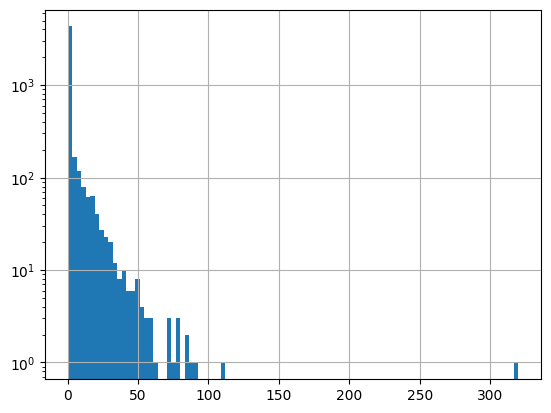

In [22]:
#Histogram of n_regulars, logaritmic to to view better.
#Hace q los 1000 y 100 esten mucho más cerca
users["n_regulars"].hist(bins=100, log=True)

Filtra el DataFrame users para incluir solo las filas donde n_regulars es menor que 100 y luego calcula y muestra estadísticas descriptivas para la columna n_regulars de esas filas filtradas.

In [23]:
users.loc[lambda x: x.n_regulars < 100].n_regulars.describe()

count    4981.000000
mean        2.396105
std         7.516721
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        90.000000
Name: n_regulars, dtype: float64

#What percentage of users save more than 10 prods.?


In [25]:
(users["n_regulars"] > 10).sum() / len(users)

0.07264699979931769

In [35]:
(users["count_people"]).count()/len(users)

0.06522175396347582

NameError: name 'plt' is not defined

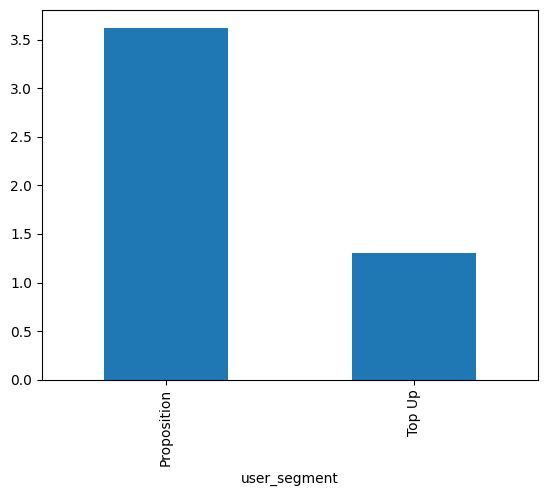

In [31]:
users.loc[lambda x: x.n_regulars < 100].groupby("user_segment")["n_regulars"].mean().plot(kind="bar")
plt.title("Average number of regulars per user segment")

(array([  3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  71.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 201.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  32.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.  , 0.07, 0.14, 0.21, 0.28, 0.35, 0.42, 0.49, 0.56, 0.63, 0.7 ,
        0.77, 0.84, 0.91, 0.98, 1.05, 1.12, 1.19, 1.26, 1.33, 1.4 , 1.47,
        1.54, 1.61, 1.68, 1.75, 1.82, 1.89, 1.96, 2.03, 2.1 , 2.17, 2.24,
        2.31, 2.38, 2.45, 2.52, 2.59, 2.66, 2.73, 2.8 , 2.87, 2.94, 3.01,
        3.08, 3.15, 3.

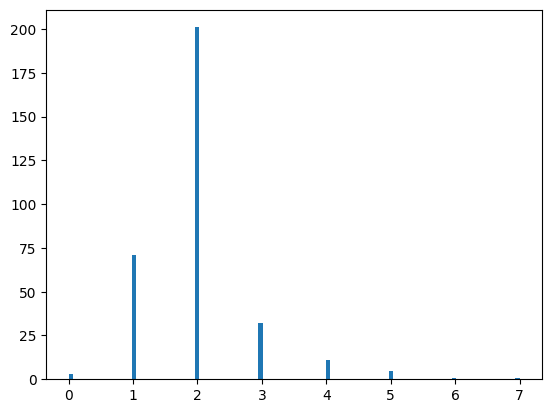

In [47]:
import matplotlib.pyplot as plt

plt.hist(users.count_adults, bins=100)

Insights:
1.Only 7% of users have regulars>10.
2.Proposition users have more regulars than "top-up" users.
3.We have family info for 6.5% ofcustomers.
4.Population mainly composed by adult couples.



2.Understanding regular products

In [48]:
regulars_df = regulars.merge(inventory, on="variant_id", how="left")
regulars_df.head()

,user_id,variant_id,created_at,price,compare_at_price,vendor,product_type,tags
0,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
1,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
2,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
3,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
4,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11,3.49,3.5,method,cleaning-products,"[cruelty-free, eco, vegan, window-glass-cleaner]"


In [49]:
regulars_df.isna().sum()

user_id                0
variant_id             0
created_at             0
price               3071
compare_at_price    3071
vendor              3071
product_type        3071
tags                3071
dtype: int64

I divide the nulls in price grouped by month, between the total number of prices I have to test the H:If prods. are being discontinuated and thats why the price does not appear. We see inventory is a picture from today, not the historical evolution.

<Axes: xlabel='created_at'>

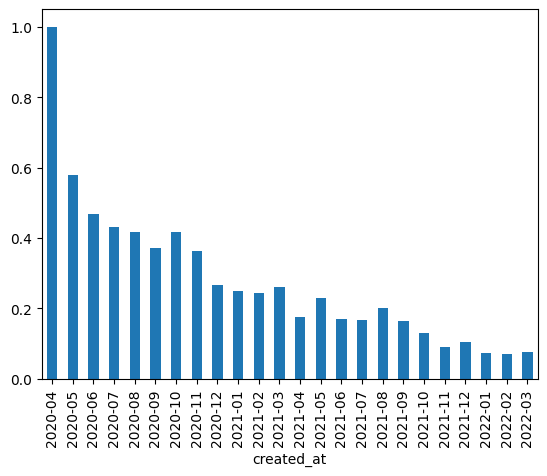

In [51]:
regulars_df.groupby(regulars_df.created_at.dt.to_period("M"))["price"].apply(lambda x: x.isna().sum() / len(x)).plot(kind="bar")

<Axes: xlabel='variant_id'>

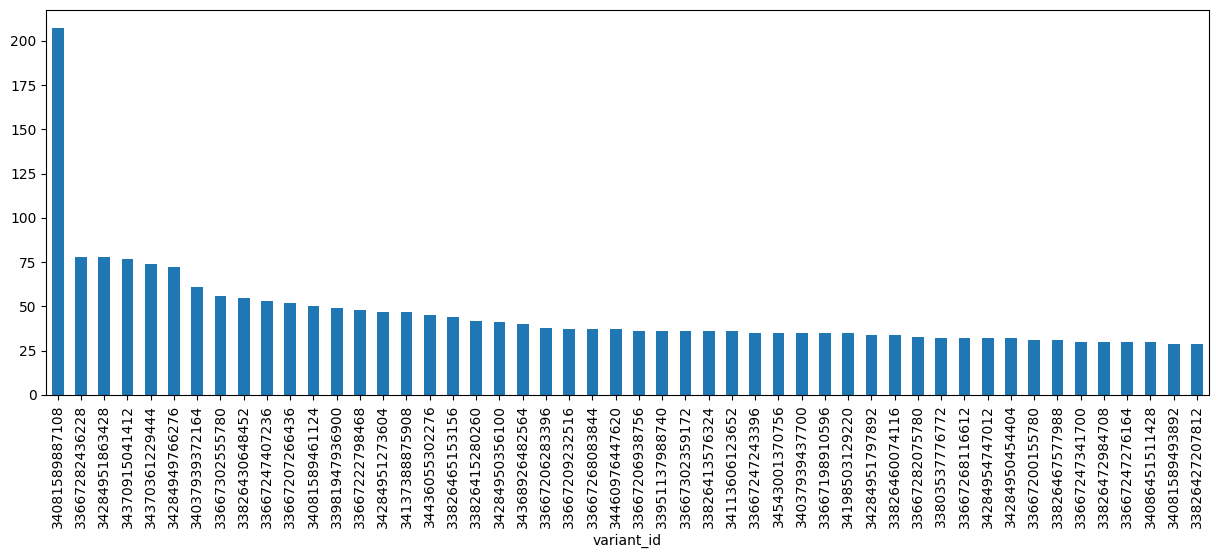

In [54]:
clean_regulars = regulars_df.dropna()

clean_regulars.groupby(["variant_id"])["user_id"].nunique().sort_values(
	ascending=False
).head(50).plot(kind="bar", figsize=(15, 5))

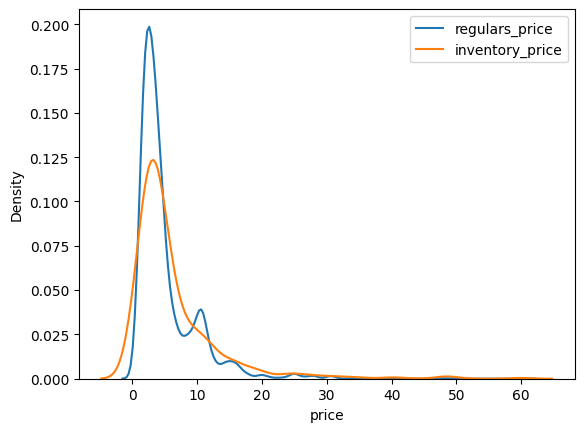

In [57]:
import seaborn as sns
sns.kdeplot(clean_regulars.price, label="regulars_price")
sns.kdeplot(inventory.price, label="inventory_price")
plt.legend()

Top 50 vendors out of regulars

Text(0.5, 1.0, 'Top 50 vendors by number of regulars (out of 367 vendors)')

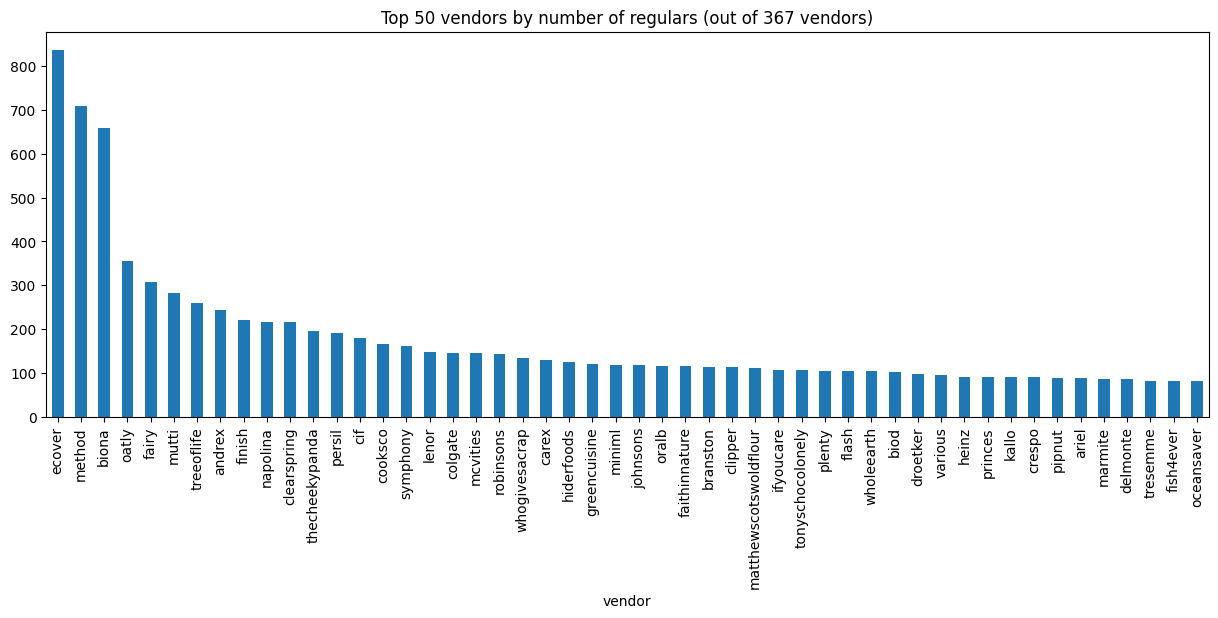

In [59]:
clean_regulars["vendor"].value_counts().head(50).plot(kind="bar", figsize=(15, 5))
plt.title(
	f"Top 50 vendors by number of regulars (out of {clean_regulars.vendor.nunique()} vendors)"
)

Top 50 products out of regulars

Text(0.5, 1.0, 'Top 50 product_types by number of regulars (out of 367 vendors)')

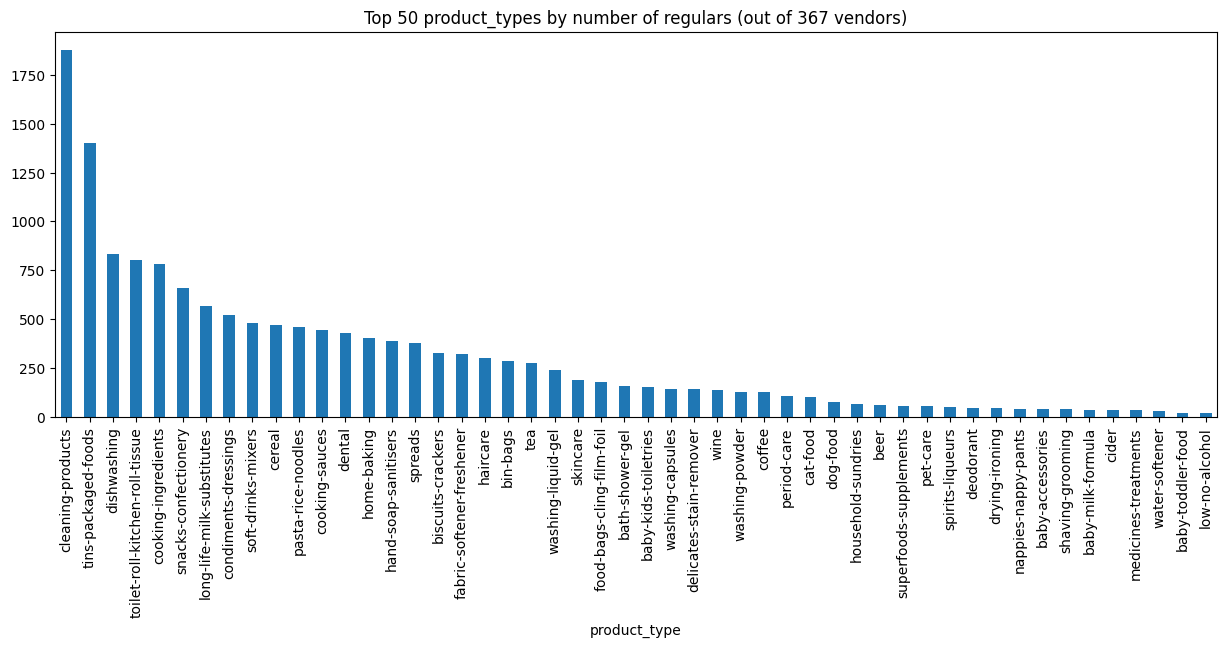

In [61]:
clean_regulars["product_type"].value_counts().head(50).plot(kind="bar", figsize=(15, 5))
plt.title(
	f"Top 50 product_types by number of regulars (out of {clean_regulars.vendor.nunique()} vendors)"
)

Prevalence of products 

In [64]:

diff_prevalence = (
	 inventory ["product_type"] 
     .value_counts (normalize=True)
	 .rename("inventory_count")
	 .reset_index()
	 .merge(
		 clean_regulars ["product_type"] 
        .value_counts (normalize=True)
		.rename("regulars_count")
		.reset_index()
	 )
.assign(invetory_rank=lambda x: x.inventory_count.rank (ascending=False)) 
.assign(regulars_rank=lambda x: x. regulars_count.rank (ascending=False))
.assign(diff=lambda x: x.inventory_count - x.regulars_count)
)

In [65]:
diff_prevalence.sort_values("regulars_count", ascending=False).head(10)

,product_type,inventory_count,regulars_count,invetory_rank,regulars_rank,diff
0,cleaning-products,0.092325,0.124850,1.0,1.0,-0.032525
1,tins-packaged-foods,0.072129,0.093255,2.0,2.0,-0.021126
21,dishwashing,0.015580,0.055474,22.0,3.0,-0.039894
31,toilet-roll-kitchen-roll-tissue,0.010387,0.053346,32.5,4.0,-0.042959
3,cooking-ingredients,0.042123,0.052148,4.0,5.0,-0.010025
2,snacks-confectionery,0.070398,0.043900,3.0,6.0,0.026498
25,long-life-milk-substitutes,0.013849,0.037648,25.5,7.0,-0.023799
6,condiments-dressings,0.030006,0.034655,7.0,8.0,-0.004649
10,soft-drinks-mixers,0.027698,0.032061,11.0,9.0,-0.004363
7,cereal,0.029429,0.031329,8.0,10.0,-0.001900
